In [1]:
# importing dependencies
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# importing scripts module
from scripts import NN
from scripts import io
from scripts import preprocess

# Part 1: Autoencoder Implementation

## (1) Constructing and Training an 8x3x8 Autoencoder

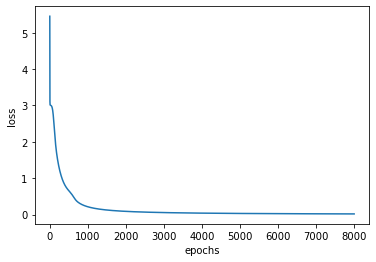

AE Reconstruction


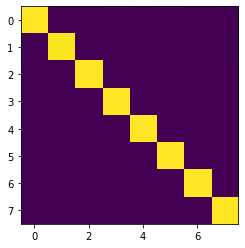

Ground Truth


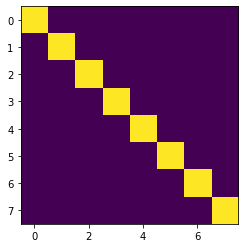

In [5]:
# Defining neccessary hyperparameters for the autoencoder
nn_architecture = [{'input_dim': 8, 'output_dim': 3, 'activation': 'sigmoid'}, 
                   {'input_dim': 3, 'output_dim': 8, 'activation': 'sigmoid'}]
loss_function = 'binary_crossentropy'
learning_rate = 1
seed = 14
epochs = 8000

# Generating autoencoder NN class instance
identity_ae = NN.NeuralNetwork(nn_architecture, lr=learning_rate, seed=seed, epochs=epochs, loss_function=loss_function)

# Defining Data for use in the autoencoder
X = np.eye(8,8)
y = X

# Training the Auto Encoder
per_epoch_loss_train, per_epoch_loss_val = identity_ae.fit(X, y, X, y)

# plotting Loss Curve
fig = plt.figure()
plt.plot(np.arange(len(per_epoch_loss_train)), per_epoch_loss_train)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()


# Plotting input vs output to show comparability
print('AE Reconstruction')
plt.imshow(identity_ae.predict(X))
plt.show()
print('Ground Truth')
plt.imshow(X)
plt.show()

# Part 2: Adapt for classification, and develop training regime

## (2) Encoding DNA sequences

In [5]:
# Reading in postive sequences
positive_seqs = io.read_text_file('./data/rap1-lieb-positives.txt')

# Reading in upstream yeast sequences
pot_neg_seqs = io.read_fasta_file('./data/yeast-upstream-1k-negative.fa')

# Randomly sampling negative sequences
negative_seqs = preprocess.sample_negative_examples(pot_neg_seqs, positive_seqs, num_samples=4000, seq_length=17)

# Generating labels
pos_labels = np.expand_dims(np.array([1]*len(positive_seqs)), axis=0)
neg_labels = np.expand_dims(np.array([1]*len(negative_seqs)), axis=0)
labels = np.hstack([pos_labels, neg_labels])

# Generating Unraveled One Hot Encoded Input Feauture --> 4*seq_length
pos_input = preprocess.encode_seqs(positive_seqs)
neg_input = preprocess.encode_seqs(negative_seqs)

## (3) Defining Training Regimine

## (4) Training NN model to predict Rap1 binding

In [ ]:
# Defining neccessary hyperparameters for the NN model
nn_architecture = [{'input_dim': 68, 'output_dim': 50, 'activation': 'sigmoid'}, 
                   {'input_dim': 50, 'output_dim': 1, 'activation': 'sigmoid'}]
loss_function = 'binary_crossentropy'
learning_rate = 1
seed = 14
epochs = 8000

# Generating NN class instance for binary classifier
bc_nn = NN.NeuralNetwork(nn_architecture, lr=learning_rate, seed=seed, epochs=epochs, loss_function=loss_function)

# Doing sinlge fold training split

# Training Model
per_epoch_loss_train, per_epoch_loss_val = identity_ae.fit(X, y, X, y)

# Part 3: Cross-Validation

## (5) K-fold CV for Evaluating NN Model's Classification

# Part 4: Project Extension

# Part 5: Evaluating Model on Final Set

# Part 6: Automated Testing with Github Workflows